# <b> Analysis </b>
### by Dr. Jesus Ocariz

We try to answer 3 questions regarding historical football penalty data.


In [1]:
#%pip install pingouin #If you need to install any package
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import geom
from datetime import datetime
import warnings
import pingouin as pg
import math

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('penalty_dataset_anonymous.csv')

# Better to deal with numerical variables (save memory, faster times for comparison...)
rep_gender ={'men': 0, 'women': 1}
rep_goal = {'PG': 1, 'PSG': 1, 'PM': 0, 'PSM': 0}
df['gender']= df['gender'].replace(rep_gender)
df['goal']= df['event_type'].replace(rep_goal)

### Q1. Is there a difference in penalty conversion rates between men and women?

In [3]:
df_m = df[df['gender']== 0]
df_f = df[df['gender']== 1]
n_m = len(df_m['gender'])
n_f = len(df_f['gender'])


print('We have '+ str(n_m) + ' male penalties in the data and '+ str(n_f)+' female')


We have 13229 male penalties in the data and 1864 female


In [4]:
g_m = len(df_m['gender'][df_m['goal']==1])
g_f = len(df_f['gender'][df_f['goal']==1])

acc_m = g_m/ n_m
acc_f = g_f/ n_f
print('Male accuracy is ' +str(acc_m) + ' and the female one is ' + str(acc_f))

Male accuracy is 0.7971879960692418 and the female one is 0.8283261802575107


The sizes of our two poblations are not comparable. So, the better way to understand if there is a difference is through a statistical analysis (using pingouin or scipy)

In [5]:
#Using pinguoin
sample_f = df_f['goal']
sample_m = df_m['goal']

pg.ttest(x=sample_m, y=sample_f, alternative='two-sided', correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.308979,2498.384391,two-sided,0.00095,"[-0.05, -0.01]",0.078018,6.555,0.883628


We calculate the T-test of the samples of goals. The null hypothesis is that these two samples have identical average (expected) values (in this case the average is the accuracy for conversion).

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [6]:
sample_f = df_f['goal']
sample_m = df_m['goal']
t_stat, p_value = stats.ttest_ind(sample_f, sample_m, equal_var= False)

alpha = 0.01
if p_value < alpha:
    print('We reject the null hypothesis: There is a difference between the samples')
else:
    print("We do not reject: The two samples are not significantly different")
t_stat, p_value = stats.ttest_ind(sample_f, sample_m, equal_var= False, alternative='greater')
if p_value < alpha:
    print('We reject the null hypothesis: The conversion of the female is greater than the male one')
else:
    print("We do not reject: The two samples are not significantly different")

We reject the null hypothesis: There is a difference between the samples
We reject the null hypothesis: The conversion of the female is greater than the male one


We <b> can </b> conclude that there is a <b> difference </b> in the conversion rate between male and female players. More precisely, women have a better conversion rate.

### Q2. Who are the best five penalty takers in the dataset?

Since we have shown that there is a difference between male and female players. We are going to give the best 5 penalty takers in each category.

There are several ways to answer this question. It depends on how we define the concept "best". On the one hand, we could try to consider who are the best at the moment or from a historical point of view. We could also try to weigh the importance of the penalty by their importance (it is not the same pressure to goal a penalty when you are 3 goals ahead that the one in the last minute to win the match or at shoouts).

We can create several features regarding the streak of annotation. We can also show only active penalty players from retired ones (we make the assumption that people who have not shooted a penalty from some date are retired. Ofc, this could be improved). And there are other several interesting features we could further analyze: the performance under different scenarios (shootout, is the team winning...). It may be interesting add further variables such as temperature, visibility conditions, weather conditions. 

Another interesting question could be to study the effect of playing away for the accuracy penalty shooting.

To continue with a higher level of complexity and more precission. It could be important to take into account the goalkeeper in the penalties. First, to evaluate and measure their abilities to save penalties goals. This would change the difficulty of scoring one penalty or another depending on the goalkeeper. To do so, we would need if the missed penalties are fault of the shooter (the ball not going inside) or merit of the goalkeeper (intercepting the ball). We could consider this as a zero-sum game between the shooting player and the goalkeeper.

An extra level would be to study the velocity of the shoot and relative trajectory with the football goal. This would be impactful to compute probabilities of scoring, understanding shooters and goalkeepers behaviours to maximize the performance at penalties.  

In [7]:
def get_streak(l):
    # l is a list of 0 and 1
    # We return a vector of the consecutive goals scored
    sol=[]
    cont = 0
    for i in range(len(l)):
        if l[i]==0:
            sol.append(cont) # We add the number of consecutive goals (possibly 0)
            if cont !=0:
                sol.append(0) # We update the cont and show that the streak has ended
                cont = 0
        else:
            cont +=1
    sol.append(cont) #We add the last element of the current streak
    return sol
        

def get_top_scorer(df, n, param1: str='accuracy', param2: str='number_goals'):
    # df is the dataframe
    # n is the number of top scorers

    allowed_values = ['accuracy', 'miss_np_accuracy', 'current_streak', 'max_streak', 'number_goals', 'active']
    if param1 not in allowed_values:
        raise ValueError(f"Invalid value for 'param'.")
    if param2 not in allowed_values:
        raise ValueError(f"Invalid value for 'param'.")

    l_players = df['player_id'].unique()
    dict_players=[]
    for player in l_players:
        aux = df[df['player_id'] == player]
        n_p = len(aux['player_id'])
        n_g = len(aux['player_id'][aux['goal']==1])
        name = aux['player_id'].unique()
        if len(name) == 1:
            name = name[0]
        else:
            print("Need to standarize the variable 'player' in the original dataset ")
        acc = n_g/n_p
        h_acc = n_g / (n_p+1)


        aux['date'] = pd.to_datetime(aux['match_date'])
        aux = aux.sort_values(by=['date', 'half', 'time'], ascending= [False, False, False])
        date_last_penalty = aux['date'].tolist()[-1]
        if date_last_penalty > datetime(2018,1,1):
            active = 1
        else:
            active = 0
            
        streak = get_streak(aux['goal'].tolist())
        c_streak = streak[-1]
        m_streak = max(streak)


        dict_players.append({'player': player, 'accuracy': acc, 'number_penalties':n_p, 'number_goals': n_g, 'miss_np_accuracy': h_acc, 
                             'streak': streak, 'current_streak': c_streak, 'max_streak': m_streak, 'name': name, 'active': active})


    top_scorer= sorted(dict_players, key=lambda x: (x[param1], x[param2], x['number_penalties']), reverse=True)
    return top_scorer[:n]

In [8]:
df

,gender,competition_id,match_date,match_id,home_team_id,away_team_id,home_score,away_score,player_id,team_id,half,time,event_type,shootout_order,goal
0,0,18,2000-06-11,631,785,272,0,0,512,785,2,89,PG,NaN,1
1,0,18,2000-06-11,9201,713,951,1,1,3933,951,2,70,PG,NaN,1
2,0,18,2000-06-16,5562,272,167,0,1,3516,272,1,35,PG,NaN,1
3,0,18,2000-06-20,9772,169,340,0,1,62,169,1,41,PG,NaN,1
4,0,18,2000-06-20,9772,169,340,2,2,3614,340,2,89,PG,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15088,0,14,2022-12-06,770,697,599,0,0,4192,697,5,122,PSG,3.0,1
15089,0,14,2022-12-06,770,697,599,0,0,2423,599,5,123,PSM,4.0,0
15090,0,14,2022-12-06,770,697,599,0,0,1951,697,5,124,PSM,5.0,0
15091,0,14,2022-12-06,770,697,599,0,0,151,599,5,125,PSM,6.0,0


In [9]:
top = get_top_scorer(df_m, 5)
[d['player'] for d in top]

[62, 2476, 2601, 693, 4415]

In [10]:
top= get_top_scorer(df_m, 5, param1='miss_np_accuracy')
[d['name'] for d in top]

[62, 2476, 2601, 766, 693]

In [11]:
top= get_top_scorer(df_m, 5, param1='current_streak')
[d['name'] for d in top]

[1643, 3508, 707, 2807, 1703]

In [12]:
top= get_top_scorer(df_m, 5, param1='max_streak')
[d['name'] for d in top]

[2310, 2473, 1866, 2758, 4210]

In [13]:
top= get_top_scorer(df_f, 5, param1='max_streak')
[d['name'] for d in top]

[3841, 1420, 909, 2198, 1916]

In [14]:
top= get_top_scorer(df_m, 5, param1='number_goals')
[d['name'] for d in top]

[2310, 2012, 1866, 2473, 2758]

In [15]:
top= get_top_scorer(df_m, 5, param1='active', param2='number_goals')
[d['name'] for d in top]

[1, 500, 2423, 599, 2476]

In [16]:
top= get_top_scorer(df_m, 5, param1='active', param2='accuracy')
[d['name'] for d in top]

[2476, 1218, 1619, 3123, 1200]

In [17]:
top= get_top_scorer(df_m, 5, param1='active', param2='current_streak')
[d['name'] for d in top]

[2476, 1, 2031, 3907, 929]

In [18]:
top= get_top_scorer(df_m, 5, param1='active', param2='max_streak')
[d['name'] for d in top]

[2476, 1, 615, 2031, 968]

In [19]:
top = get_top_scorer(df_f, 5)
[d['name'] for d in top]

[1420, 4311, 2962, 2613, 1956]

In [20]:
top= get_top_scorer(df_f, 5, param1='miss_np_accuracy')
[d['name'] for d in top]

[1420, 4311, 2962, 2613, 1956]

In [21]:
top= get_top_scorer(df_f, 5, param1='current_streak')
[d['name'] for d in top]

[3841, 1420, 909, 2198, 1916]

In [22]:
top= get_top_scorer(df_f, 5, param1='max_streak')
[d['name'] for d in top]

[3841, 1420, 909, 2198, 1916]

In [23]:
top= get_top_scorer(df_f, 5, param1='number_goals')
[d['name'] for d in top]

[1067, 3841, 701, 2198, 1978]

### Q3. Analysis to help a team decide the order of their first 5 penalty takers in a shootout

We are going to focus on male teams because we have more data (and thus we can provide better insights). Let us study for example the national team of Argentina (team_id=638).

In [24]:
df2 =df_m[df_m['half']==5]

df2['team_id'].value_counts()

team_id
714    35
638    35
630    35
599    31
72     30
       ..
912     3
90      3
825     3
668     3
590     3
Name: count, Length: 141, dtype: int64

In [25]:
df2_arg= df2[df2['team_id']==638]
df_arg = df.loc[(df['team_id']==638) & (df['half']!= 5)]


n_shootout = len(df2_arg)
print(n_shootout)
n_normal = len(df_arg)
print(n_normal)

g_shootout = len(df2_arg['gender'][df2_arg['goal']==1])
g_normal = len(df_arg['gender'][df_arg['goal']==1])
acc_s = g_shootout/ n_shootout
acc_n = g_normal/ n_normal
print('Argentina games: Shootut accuracy is ' +str(acc_s) + ' and the normal one is ' + str(acc_n))


35
11
Argentina games: Shootut accuracy is 0.6571428571428571 and the normal one is 0.8181818181818182


We can see that there is an importance difference between the conversion rate for penalties Argentina matches.

In [26]:
sample_1 = df2_arg['goal']
sample_2 = df_arg['goal']
t_stat, p_value = stats.ttest_ind(sample_1, sample_2, equal_var= False)

print(p_value)
alpha = 0.05
if p_value < alpha:
    print('We reject the null hypothesis: There is a difference between the samples')
else:
    print("We do not reject: The two samples are not significantly different")

0.2853280039756311
We do not reject: The two samples are not significantly different


We cannot confirm that Argentinian players underperform in shoouts due to our Hypothesis testing. We have very few data of normal penalties for Argentina in our dataset (11). We can study the performance of the Argentinian players in their teams to have more data.

In [27]:
df3 = df[df['gender'] == 0] # To see all the players

df3_n = df3[df3['half']!=5]
df3_s = df3[df3['half']==5]
n_shootout = len(df3_s)
print("The number of shootout " +str(n_shootout))
n_normal = len(df3_n)
print("The number of shootout " +str(n_normal))
g_shootout = len(df3_s['gender'][df3_s['goal']==1])
g_normal = len(df3_n['gender'][df3_n['goal']==1])
acc_s = g_shootout/ n_shootout
acc_n = g_normal/ n_normal

print('Male players: Shootut accuracy is ' +str(acc_s) + ' and the normal one is ' + str(acc_n))
fail_prob = 1-acc_s # We save this for later
sample_1 = df3_s['goal'].tolist()
sample_2 = df3_n['goal'].tolist()
t_stat, p_value = stats.ttest_ind(sample_1, sample_2, equal_var= False)

alpha = 0.05
print(p_value)
if p_value < alpha:
    print('We reject the null hypothesis: There is a difference between the samples')
else:
    print("We do not reject: The two samples are not significantly different")

The number of shootout 1226
The number of shootout 12003
Male players: Shootut accuracy is 0.7177814029363785 and the normal one is 0.8052986753311672
7.918475251080391e-11
We reject the null hypothesis: There is a difference between the samples


In [28]:
df_arg_tot = pd.concat([df_arg, df2_arg])
l_player_arg = df_arg_tot['player_id'].unique()
print(len(l_player_arg))
df3 =df.loc[df['player_id'].isin(l_player_arg)]
#df3 = df[df['gender'] == 0] # To see all the players

df3_n = df3[df3['half']!=5]
df3_s = df3[df3['half']==5]
n_shootout = len(df3_s)
print("The number of shootout " +str(n_shootout))
n_normal = len(df3_n)
print("The number of normal " +str(n_normal))
g_shootout = len(df3_s['gender'][df3_s['goal']==1])
print(g_shootout)
g_normal = len(df3_n['gender'][df3_n['goal']==1])
acc_s = g_shootout/ n_shootout
acc_n = g_normal/ n_normal


print('Argentina players: Shootut accuracy is ' +str(acc_s) + ' and the normal one is ' + str(acc_n))


25
The number of shootout 36
The number of normal 306
23
Argentina players: Shootut accuracy is 0.6388888888888888 and the normal one is 0.7973856209150327


In [29]:
sample_1 = df3_n['goal']
sample_2 = df3_s['goal']
pg.ttest(x=sample_1, y=sample_2, alternative='two-sided', correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.878179,40.820981,two-sided,0.067512,"[-0.01, 0.33]",0.384599,0.931,0.585771


In [30]:
sample_1 = df3_s['goal'].tolist()
sample_2 = df3_n['goal'].tolist()
t_stat, p_value = stats.ttest_ind(sample_1, sample_2, equal_var= False)

alpha = 0.05
print(p_value)
if p_value < alpha:
    print('We reject the null hypothesis: There is a difference between the samples')
else:
    print("We do not reject: The two samples are not significantly different")

0.06751243866907324
We do not reject: The two samples are not significantly different


From a statistical point of view, we cannot state the difference of conversion between with alpha =0.05 (standard one used). But the scenario changes if we take alpha=0.1 (depending how much impactful we consider the error types I and II). One possibility could be to manually add the data previous to 2000 (for example Worl Cup 1990: 3/5 vs Yugoslavia and 4/4 vs Italy; France 1998: 4/5 vs England; Qataer 2022: 4/5 vs Netherlands, 4/4 vs France )

In [31]:
new_acc_s = (g_shootout+11)/ (n_shootout+14)
print(new_acc_s)
n_list = [1]*19 + [0]*4

sample_1 = df3_s['goal'].tolist() + n_list
sample_2 = df3_n['goal'].tolist()
t_stat, p_value = stats.ttest_ind(sample_1, sample_2, equal_var= False)

alpha = 0.05
print(p_value)
if p_value < alpha:
    print('We reject the null hypothesis: There is a difference between the samples')
else:
    print("We do not reject: The two samples are not significantly different")

n_cr = (23+19)/(36+23)
print(n_cr)

0.68
0.18384305453579997
We do not reject: The two samples are not significantly different
0.711864406779661


In [32]:
pg.ttest(x=sample_1, y=sample_2, alternative='two-sided', correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.341165,76.350768,two-sided,0.183843,"[-0.21, 0.04]",0.207706,0.358,0.307788


Conclusion: to determine which are the best Argentinian penalty shooters we will consider all the penalties (and not only shoout ones). However, we know that with the full male data that there is a difference between the conversion rate between shootout and normal penalties. We are considering all the penalties the same but in a more detailed version I would weight them.

The next step is try to understand what are the key factors to win a shoout. More precisely, we are going to study the following questions:
- Is it important to be the firt team to shoot or the second?
- Some years ago, there was the policy of leaving the best players to shoot at the end. Now, it is the other way around and best players shoot the first. Which policy could work best?

(Note this is a analysis for male football. A similar one could be done for female with more data)

In [33]:
df2 = df[df['half']==5]
df2['gender'].value_counts()

gender
0    1226
1     163
Name: count, dtype: int64

In [34]:
df2 = df2[df2['gender']==0]
l_match = df2['match_id'].unique()
df2['score_shootout']= 0
df2 = df2.reset_index(drop=True)

inf_match=[]
# 0 for second order and 1 first order
for m in l_match:
    aux = df2[df2['match_id'] == m]
    first_team_miss = -1
    first_miss = -1
    team_win = -1
    diff = 0
    ind = 0
    for i in range(len(aux)):
        ind = aux.index[aux['shootout_order']== (i+1)].tolist()[0]
        res = aux.at[ind, 'goal']
        if first_team_miss == -1 and res == 0:
            first_miss = i+1
            first_team_miss = (first_miss)%2
            
        df2.at[ind, 'score_shootout'] = diff
        if i%2 == 0:
            diff += res
        else:
            diff -= res
    score = df2.at[ind, 'score_shootout']
    if score >0:
        team_win = 1
    else:
        team_win = 0
    inf_match.append({'match': m, 'team_win': team_win, 'score': diff, 'size': len(aux), 
                      'first_miss': first_miss, 'first_team_miss': first_team_miss
                      })

        


Let us try to understand better the new features.

In [35]:
df_match = pd.DataFrame(inf_match)
df_match.describe()
# df_match['team_win'].mean() 0.56666

,match,team_win,score,size,first_miss,first_team_miss
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,6147.925000,0.566667,0.450000,10.216667,4.516667,0.566667
std,3539.994529,0.497613,1.613233,3.308211,3.906434,0.497613
min,42.000000,0.000000,-3.000000,6.000000,1.000000,0.000000
25%,3074.500000,0.000000,-1.000000,9.000000,2.000000,0.000000
50%,6329.500000,1.000000,1.000000,9.500000,3.000000,1.000000
75%,8969.000000,1.000000,2.000000,10.000000,6.000000,1.000000
max,12009.000000,1.000000,3.000000,26.000000,23.000000,1.000000


Since we have a number bigger than 0.5, we can think that being first could be better.

In [36]:
l = len(df_match) //2
sample_1 = df_match['team_win'].tolist()
sample_2 = [1]*l + [0]*l
t_stat, p_value = stats.ttest_ind(sample_1, sample_2, equal_var= False)

alpha = 0.05
print(p_value)
if p_value < alpha:
    print('We reject the null hypothesis: There is a difference between the samples')
else:
    print("We do not reject: The two samples are not significantly different")

0.30261282982246446
We do not reject: The two samples are not significantly different


There is not enough statistical proof to prove that the distribution of winnings being first is different from a random one. However, from a historical point of view I would recommend to be the <b> first </b> to shoot.

In [37]:
bins=[0,9,10,100]
#labels=[-1, 0, 1]
df_match['duration']=pd.cut(df_match['size'], bins= bins)#, labels = labels)
df_match

,match,team_win,score,size,first_miss,first_team_miss,duration
0,3027,0,-1,10,3,1,"(9, 10]"
1,4282,0,-1,10,3,1,"(9, 10]"
2,10632,1,2,9,8,0,"(0, 9]"
3,5232,1,2,9,8,0,"(0, 9]"
4,1005,0,-2,8,1,1,"(0, 9]"
...,...,...,...,...,...,...,...
115,2266,0,-1,10,2,0,"(9, 10]"
116,4944,0,-1,12,1,1,"(10, 100]"
117,7101,1,2,8,2,0,"(0, 9]"
118,3207,0,-2,8,1,1,"(0, 9]"


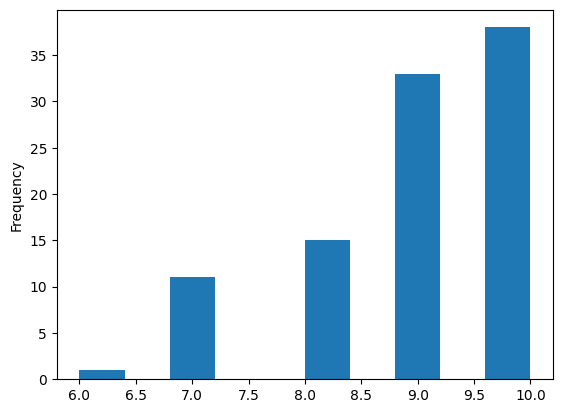

In [38]:
df_match['size'][df_match['size'] <= 10].plot(kind='hist')
plt.show()

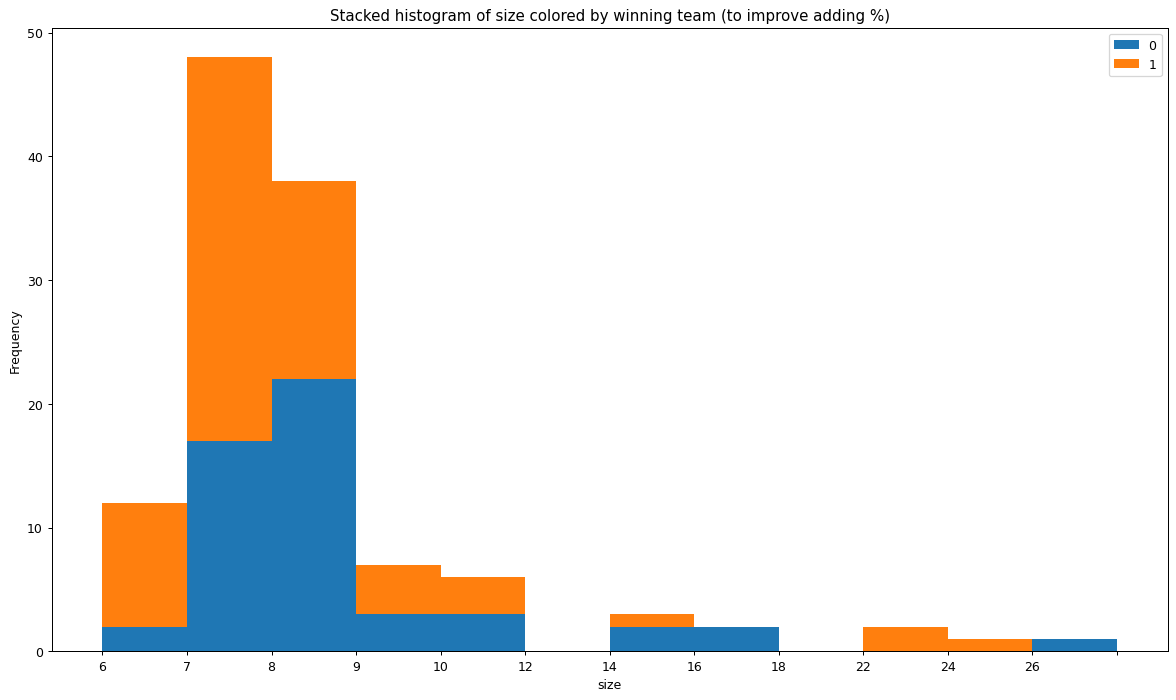

In [39]:
x_var = 'size'
groupby_var = 'team_win'
df_agg = df_match.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

plt.figure(figsize=(16,9), dpi = 90)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df_match[x_var].unique().__len__(), stacked = True, density = False) #color = colors[:len(vals)],

plt.legend({group: col for group, col in zip(np.unique(df_match[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked histogram of size colored by winning team (to improve adding %)")
plt.xlabel(x_var)
plt.ylabel("Frequency")
labels= np.unique(df_match[x_var]).tolist()
labels += [' ']
plt.xticks(ticks=bins, labels = labels)
plt.show()

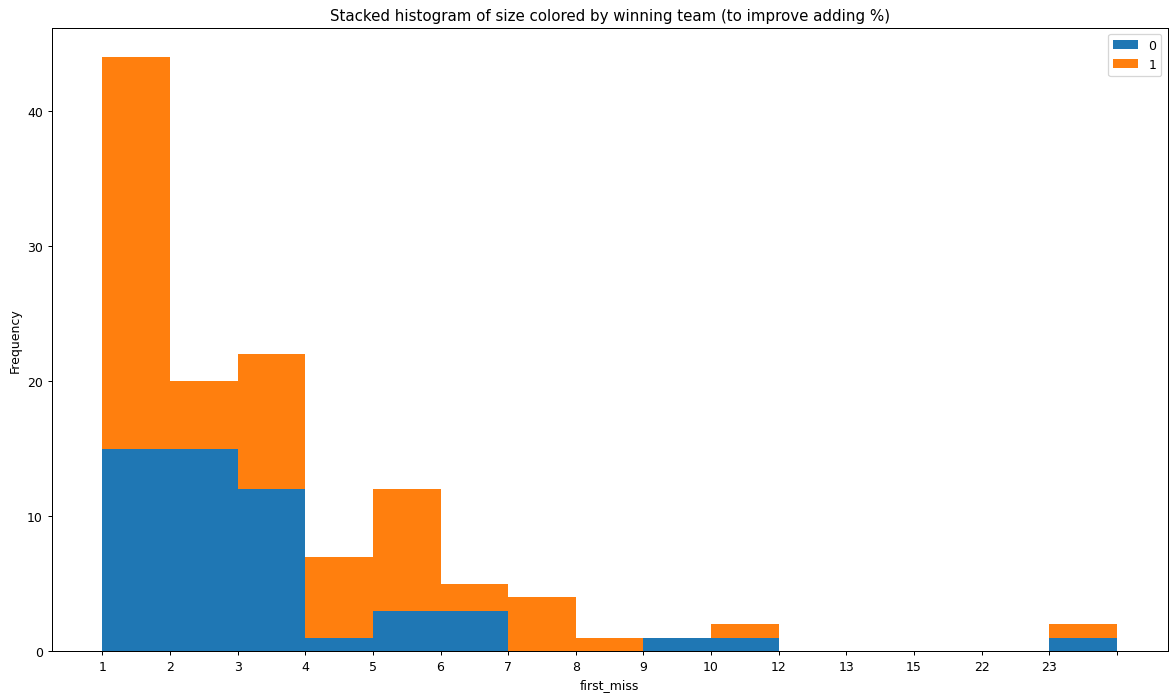

In [40]:
x_var = 'first_miss'
groupby_var = 'team_win'
df_agg = df_match.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

plt.figure(figsize=(16,9), dpi = 90)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, df_match[x_var].unique().__len__(), stacked = True, density = False) #color = colors[:len(vals)],

plt.legend({group: col for group, col in zip(np.unique(df_match[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked histogram of size colored by winning team (to improve adding %)")
plt.xlabel(x_var)
plt.ylabel("Frequency")
labels= np.unique(df_match[x_var]).tolist()
labels += [' ']
plt.xticks(ticks=bins, labels = labels)
plt.show()

If we assume that failing a penalty follows a Bernoulli distribution, the previous plot should be similar to a geometric distribution.

[]

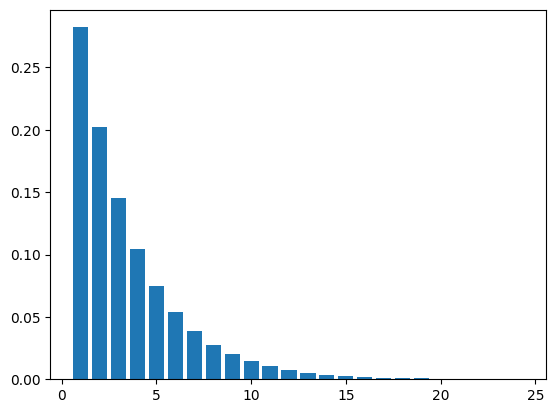

In [41]:
k_values = np.arange(1, 25)
pmf_values = geom.pmf(k_values, fail_prob)

plt.bar(k_values, pmf_values)
plt.plot()

In [42]:
condm1 = (df_match['first_team_miss'] == 1)
condm0 = (df_match['first_team_miss'] == 0)
condw1 = (df_match['team_win'] == 1)
condw0 = (df_match['team_win'] == 0)
cond = (df_match['first_miss'] == 1)
notcond = (df_match['first_miss'] != 1)


N = len(df_match)
print(N)
n_w1m1 = len(df_match[condw1 & condm1 ])
n_w1m0 = len(df_match[condw1 & condm0 ])
n_w0m0 = len(df_match[condw0 & condm0 ])
n_w0m1 = len(df_match[condw0 & condm1 ])

n_w1f1 = len(df_match[condw1 & cond ])
n_w1g1 = len(df_match[condw1 & notcond])
n_w0f1 = len(df_match[condw0 & cond ])
n_w0g1 = len(df_match[condw0 & notcond])


pw1 = (n_w1m1+n_w1m0)/N
pw0 = (n_w0m1+n_w0m0)/N
pw1_condm1 = (n_w1m1)/(n_w1m1+n_w0m1)
pw0_condm1 = (n_w0m1)/(n_w1m1+n_w0m1)
pw1_condm0 = (n_w1m0)/(n_w1m0+n_w0m0)
pw0_condm0 = (n_w0m0)/(n_w1m0+n_w0m0)


pw1_g1 = (n_w1g1)/(n_w1g1+n_w0g1)
pw1_f1 = (n_w1f1)/(n_w1f1+n_w0f1)
print('We know that the probability of winning shooting first is '+ str(pw1))

print('The conditional probability of winning shooting first when we are the first team to miss is '+ str(pw1_condm1))
print('The conditional probability of winning shooting first when the other team is the first to miss is '+ str(pw1_condm0))
print('The conditional probability of winning shooting first when we fail the first shoot is '+ str(pw1_f1))
print('The conditional probability of winning shooting first when we score the first shoot is '+ str(pw1_g1))

120
We know that the probability of winning shooting first is 0.5666666666666667
The conditional probability of winning shooting first when we are the first team to miss is 0.29411764705882354
The conditional probability of winning shooting first when the other team is the first to miss is 0.9230769230769231
The conditional probability of winning shooting first when we fail the first shoot is 0.391304347826087
The conditional probability of winning shooting first when we score the first shoot is 0.6082474226804123


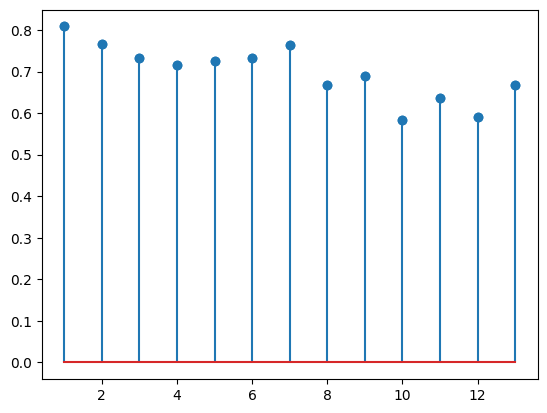

In [43]:
prob_scoring=[]
for i in range(13):
    j = i+1
    aux = df2[df2['shootout_order']== j]
    prob_scoring.append(aux['goal'].mean())
r = [1+i for i in range(len(prob_scoring))]

plt.stem(r, prob_scoring)
plt.scatter(r, prob_scoring)
plt.show()

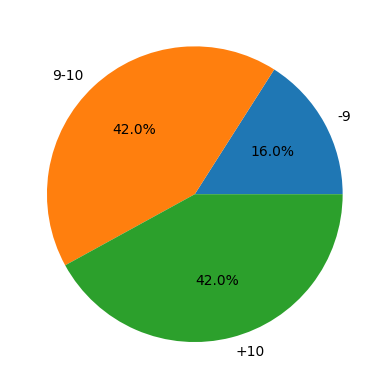

In [44]:
N = len(df_match)
c1 = len(df_match[df_match['size']<= 8])
c3 = len(df_match[df_match['size'] > 10])
c2 = N-c1-c3

p1 = c1*100./N
p2 = c2*100./N
p3 = c2*100./N

plt.pie([p1,p2,p3], labels=['-9', '9-10', '+10'], autopct='%1.1f%%')
plt.show()

In [45]:
df_arg_tot = pd.concat([df_arg, df2_arg])
l_player_arg = df_arg_tot['player_id'].unique().tolist() 
l_player_arg += [887] # We add Paulo Dybala (887)

l_player_arg = [887, 2012, 2475, 3432] #To comment if needed

df3 =df.loc[df['player_id'].isin(l_player_arg)]

top= get_top_scorer(df3, 5, param1='max_streak')
[d['name'] for d in top]

[2012, 887, 2475, 3432]

In [46]:
top= get_top_scorer(df3, 10, param1='active', param2='current_streak')
[d['name'] for d in top]

[2475, 3432, 887, 2012]

In [47]:
top= get_top_scorer(df3, 10, param1='active', param2='current_streak')
[d['name'] for d in top]

[2475, 3432, 887, 2012]

In [48]:
allowed_values = ['accuracy', 'miss_np_accuracy', 'current_streak', 'max_streak', 'number_goals']

for crit in allowed_values:
    top= get_top_scorer(df3, 10, param1=crit)
    print([d['name'] for d in top])
    print([d[crit] for d in top])

[3432, 887, 2012, 2475]
[1.0, 0.8846153846153846, 0.7981651376146789, 0.6875]
[887, 2012, 2475, 3432]
[0.8518518518518519, 0.7909090909090909, 0.6470588235294118, 0.5]
[887, 2012, 2475, 3432]
[14, 8, 4, 1]
[2012, 887, 2475, 3432]
[16, 14, 4, 1]
[2012, 887, 2475, 3432]
[87, 23, 11, 1]


#### Hypothesis testing (Bernoulli distribution)
For small number of samples $N$ we use the binomial distribution.
For larger $N$, we use the normal distribution.

Our mean estimator $\overline{X}=\frac{1}{N}\sum_{i=1}^{N} X_i$ is a sum of $N$ draws from the same distribution. Under the null hypothesis (that the Bernoulli parameter $p=p_0$), the expected value of $E[\overline{X}]= p_0$. If the N draws are independent, the variance of $\overline{X}$ is simply the sum of the variances of the $X_i$ draws (and the scalar goes to a square): $var(\overline{X})=\frac{1}{N^2} N Var[X_i]= \frac{1}{N}p_0 (1-p_0)$. 

The central limit theorem tells us that for large $N$, $Z=\dfrac{\overline{X}-E[\overline{X}]}{\sqrt{Var[\overline{X}]}}=\sqrt{N}\dfrac{\overline{X} - p_0}{\sqrt{p_0 (1-p_0)}}$ converges in distribution to a standard normal distribution $\mathcal{N}(0,1)$.


In [49]:
#If we want to do the statistical hypothesis with our own code

def right_hypothesis_bernoulli(X_mean, N, p, alpha):
    sigma = math.sqrt(p*(1-p))
    return right_hypothesis(X_mean, N, p, sigma, alpha)

def right_hypothesis(X_mean, N, mu, sigma, alpha):
    percentile = scipy.stats.norm.ppf(1-alpha)
    print(percentile)
    value = math.sqrt(N)*(X_mean- mu)/(sigma)
    print(value)
    return value>percentile #1 we reject the null hypothesis. The error Type I of rejecting wrong the null hypothesis is alpha (small)

In [50]:
X_mean = df_match['team_win'].mean()
print(X_mean)
N = len(df_match['team_win'])
print(N)
alpha = 0.05

right_hypothesis_bernoulli(X_mean, N, 0.5, alpha)

0.5666666666666667
120
1.6448536269514722
1.4605934866804426


False